In [2]:
%load_ext autoreload
%autoreload 2

In [49]:
import numpy as np
import pandas as pd
from naca import NacaGenerator
from panel import Panel

import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
NACA = '2412'
NUM_POINTS_X = 10

In [5]:
def generate_airfoil(NACA, NUM_POINTS_X):
    airfoil = NacaGenerator(naca=NACA)

    airfoil.generate_cosine_distribution(N=NUM_POINTS_X);
    airfoil.generate_naca();
    
    return airfoil

In [6]:
airfoil = generate_airfoil(NACA, NUM_POINTS_X=100)

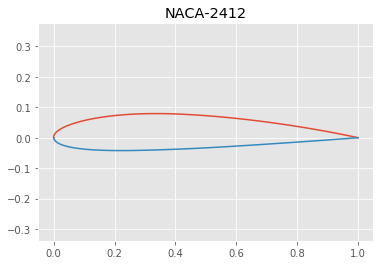

In [7]:
airfoil.plot()

In [8]:
x, y = airfoil.clockwise_naca()

In [9]:
panels = []

for x_start, x_end, y_start, y_end in zip(x, x[1:], y, y[1:]):
    
    start = np.array([x_start, y_start])
    end   = np.array([x_end,   y_end])
    
    panel = Panel(start=start, end=end)
    
    panels.append(panel)

In [10]:
NUM_PANELS = len(panels)
print('Number of panels:', NUM_PANELS)

Number of panels: 198


In [11]:
mid_points = []
thetas     = []

for panel in panels:
    
    mid_points.append({'x_c': panel.mid_point})
    thetas.append(panel.angle)

In [37]:
boundary_points = []
control_points  = []

for panel in panels:
    
    # Start
    boundary_points.append({'x':panel.start[0], 'y': panel.start[1], 
                            'S':panel.length,   'theta':panel.angle, 
                            'x_c': panel.mid_point_x, 'y_c': panel.mid_point_y})
    # End
    boundary_points.append({'x':panel.end[0], 'y': panel.end[1], 
                            'S':panel.length, 'theta':panel.angle, 
                            'x_c': panel.mid_point_x, 'y_c': panel.mid_point_y})
    
    # Middle point
    control_points.append({'S':panel.length,   'theta':panel.angle, 
                           'x': panel.mid_point_x, 'y': panel.mid_point_y})

In [38]:
N_c = len(control_points)
N_b = len(boundary_points)

print(f'We have {N_c} control points.')
print(f'We have {N_b} boundary points.')

We have 198 control points.
We have 396 boundary points.


In [91]:
A = np.zeros(shape = (N_c, N_b))
B = np.zeros(shape = (N_c, N_b))
C = np.zeros(shape = (N_c, N_b))
D = np.zeros(shape = (N_c, N_b))
E = np.zeros(shape = (N_c, N_b))
F = np.zeros(shape = (N_c, N_b))
G = np.zeros(shape = (N_c, N_b))
P = np.zeros(shape = (N_c, N_b))
Q = np.zeros(shape = (N_c, N_b))

C1 = np.zeros(shape = (N_c, N_b))
C2 = np.zeros(shape = (N_c, N_b))

for row, control in enumerate(control_points, start = 0):
    
    for col, boundary in enumerate(boundary_points, start = 0):
        
        dx = (control['x'] - boundary['x'])
        dy = (control['y'] - boundary['y'])
        
        A[row][col] -= dx * np.cos(boundary['theta'])
        A[row][col] -= dy * np.sin(boundary['theta'])
        
        B[row][col] += dx**2.0 + dy**2.0
        
        C[row][col] += np.sin(control['theta'] - boundary['theta'])
        
        D[row][col] += np.cos(control['theta'] - boundary['theta'])
        
        E[row][col] += dx * np.sin(boundary['theta'])
        E[row][col] -= dy * np.cos(boundary['theta'])
        
        S = boundary['S']
        
        num = S ** 2.0 - 2.0 * A[row][col] * S
        den = B[row][col]
        
        F[row][col] += np.log(1.0 + num / den)
        
        num = E[row][col] * S
        den = B[row][col] + A[row][col] * S
        
        G[row][col] += np.arctan(num / den)
        
        P[row][col] += dx * np.sin(control['theta'] - 2.0 * boundary['theta'])
        P[row][col] += dy * np.cos(control['theta'] - 2.0 * boundary['theta'])
        
        Q[row][col] += dx * np.cos(control['theta'] - 2.0 * boundary['theta'])
        Q[row][col] -= dy * np.sin(control['theta'] - 2.0 * boundary['theta'])
    
        C2[row][col] += D[row][col] 
        C2[row][col] += Q[row][col] * F[row][col] / 2.0 / S 
        C2[row][col] -= A[row][col] * C[row][col] * G[row][col] / S
        C2[row][col] -= D[row][col] * E[row][col] * G[row][col] / S
        
        C1[row][col] += D[row][col] * F[row][col] / 2.0
        C1[row][col] += C[row][col] * G[row][col]
        C1[row][col] -= C2[row][col]

np.fill_diagonal(C1, -1)
np.fill_diagonal(C2,  1)

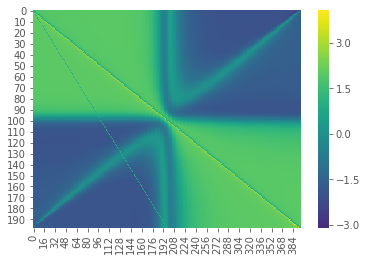

In [94]:
sns.heatmap(C2, cmap = 'viridis', center = 0.0)

In [95]:
K = np.zeros(shape = (N_b, N_b))

In [ ]:
for row in range(C1.shape[0]):
    
    for col in range(C2.shape[1]):
        
        